In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## 2. Train the model

In [80]:
# Path
csv_file = 'modified/sample_2000.csv' 
image_dir = 'modified_image/'         

#Read
data = pd.read_csv(csv_file, header=None, names=['user_id', 'image', 'emotion'])

image_size = (224, 224) 
images = []
labels = []
for _, row in data.iterrows():
    image_path = os.path.join(image_dir, row['image'])
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size) / 255.0  
        images.append(img)
        labels.append(row['emotion'])

#convert to numpy arrays
images = np.array(images)
labels = pd.get_dummies(labels).values 

# Visualize the data:

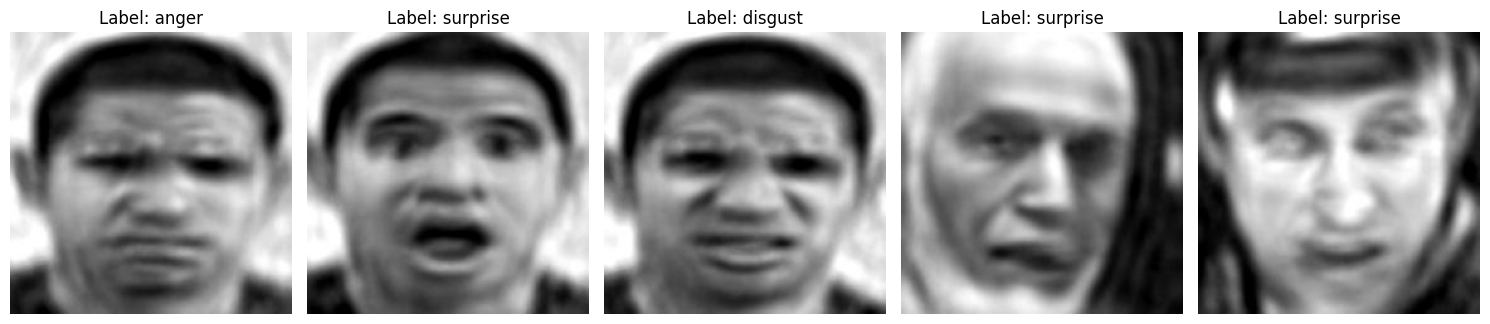

In [81]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {data['emotion'][i+1]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Prepare the dataset, utilizes data augmentation

In [82]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [83]:
np.unique(y_train)


array([False,  True])

In [84]:
integer_labels = np.argmax(labels, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(integer_labels), 
    y=integer_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.3227513227513228, 1: 1.6025641025641026, 2: 0.7374631268436578, 3: 0.7374631268436578, 4: 1.243781094527363, 5: 0.9057971014492754}


In [85]:
model = models.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),  
    layers.Dense(labels.shape[1], activation='softmax')  ])

optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16, class_weight=class_weights_dict)


c:\Users\Eric\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.2280 - loss: 1.7973 - val_accuracy: 0.3938 - val_loss: 1.4785
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 400ms/step - accuracy: 0.4498 - loss: 1.3817 - val_accuracy: 0.4563 - val_loss: 1.3159
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.5676 - loss: 1.1600 - val_accuracy: 0.4563 - val_loss: 1.3318
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 383ms/step - accuracy: 0.6229 - loss: 1.0222 - val_accuracy: 0.4812 - val_loss: 1.3414
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 397ms/step - accuracy: 0.6800 - loss: 0.8351 - val_accuracy: 0.4750 - val_loss: 1.2890
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 388ms/step - accuracy: 0.7715 - loss: 0.6574 - val_accuracy: 0.5063 - val_loss: 1.3294
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 391ms/step - accuracy: 0.8041 - loss: 0.5506 - val_accuracy: 0.5000 - val_loss: 1.4272
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - accuracy: 0.8491 - loss: 0.3915 - val_accu

# Visulize the performance

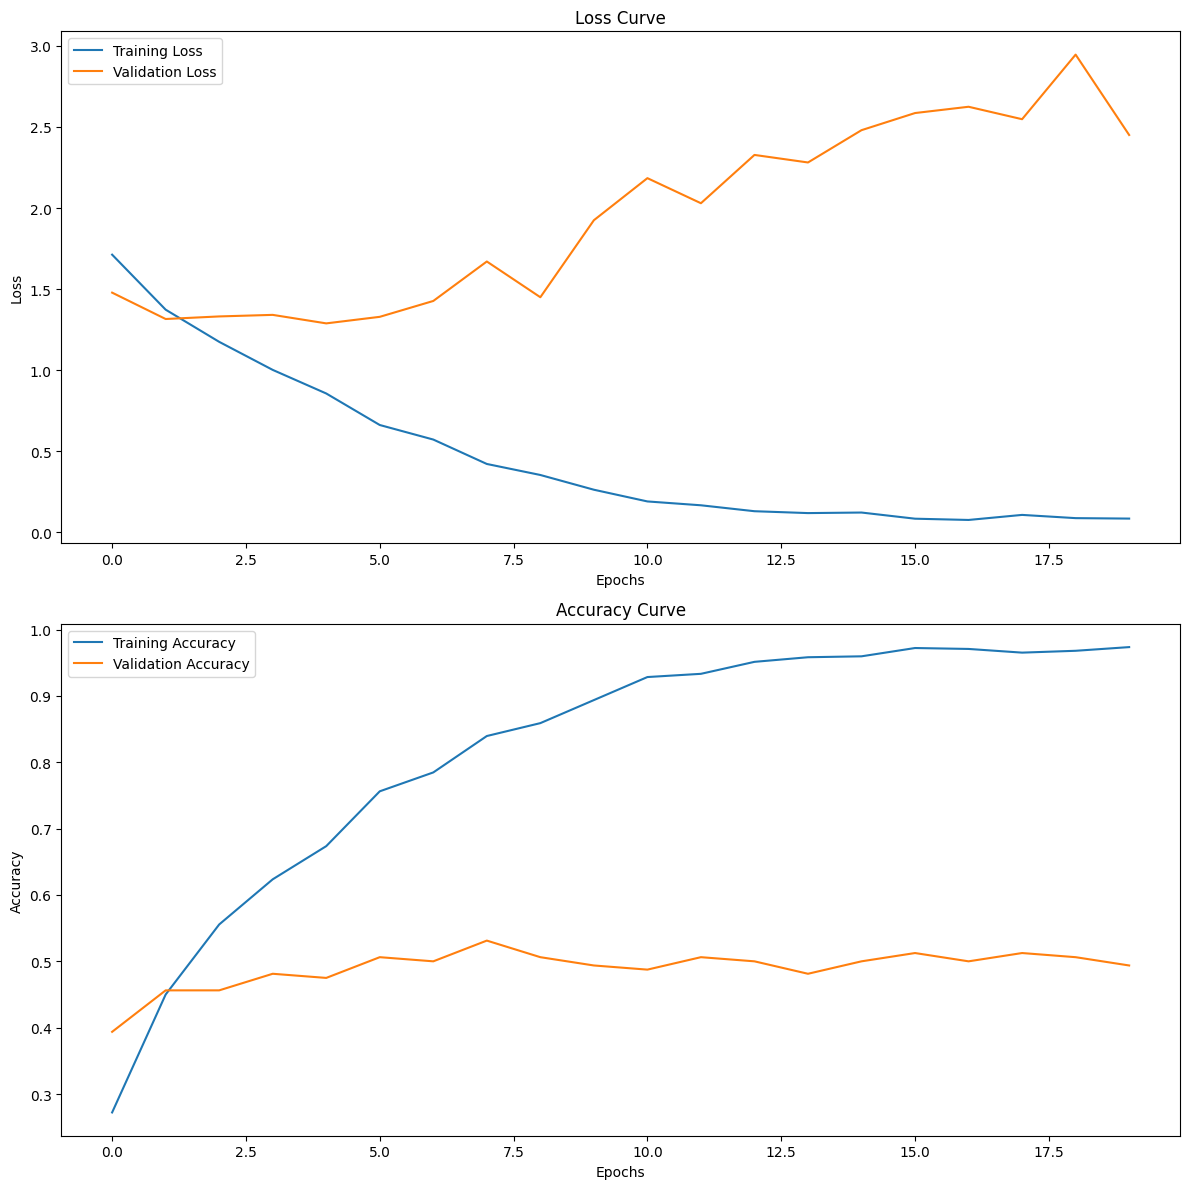

In [86]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


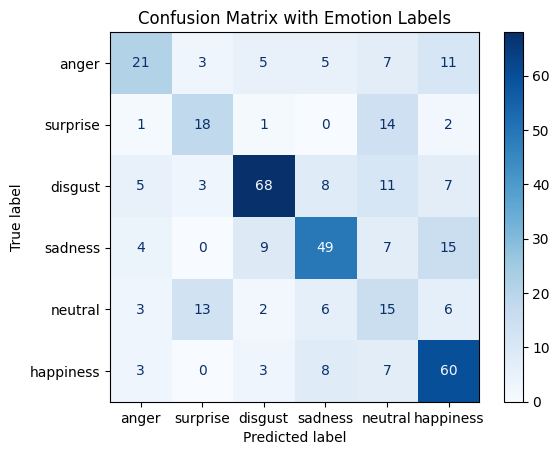

In [87]:
y_pred = model.predict(X_test)
emotion_labels = data[1:]['emotion'].unique()

y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Emotion Labels')
plt.show()

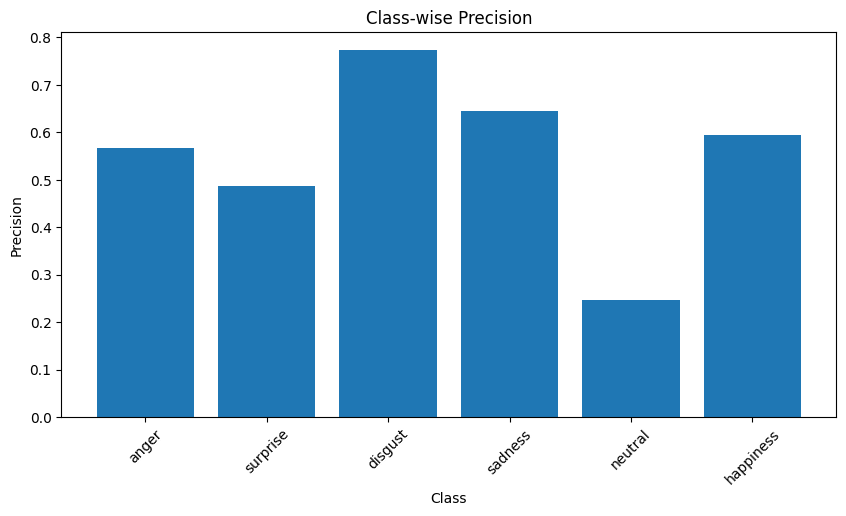

In [88]:
report = classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels, output_dict=True, zero_division=0)
class_precisions = [report[label]['precision'] for label in emotion_labels if label in report]

# Plot class-wise precision
plt.figure(figsize=(10, 5))
plt.bar(emotion_labels, class_precisions)  # Use class labels for the x-axis
plt.title('Class-wise Precision')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()